# 逻辑回归

假设函数：$h(x)=\frac{1}{1+e^{-X\theta}}=p(y=1|X,\theta)=p$

参数：$\theta=(\theta_0,...,\theta_n)^{'}$

最大似然函数：$L=\prod^{m}_{i=1}p^{y^{(i)}}(1-p)^{1-y^{(i)}}$

代价函数：$J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\ln(h(x))+(1-y^{(i)})\ln(1-h(x))$

梯度：$\bigtriangledown J(\theta)=\frac{1}{m}X^{'}(h(x)-y)$

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# wh_data = pd.read_csv('../AQI_maincity/武汉.csv', index_col='date', encoding='utf-8', engine='python')
wh_data = pd.read_csv('武汉.csv', index_col='date', encoding='utf-8', engine='python')
wh_data.drop(wh_data[wh_data['质量等级']=='无'].index, inplace=True)
wh_data.head()

,AQI,质量等级,PM2.5,PM10,SO2,CO,NO2,O3_8h
date,,,,,,,,
2014-01-01,203,重度污染,153,210,70,2.0,106,55
2014-01-02,231,重度污染,181,254,89,2.4,112,26
2014-01-03,224,重度污染,174,226,63,1.7,84,55
2014-01-04,147,轻度污染,112,184,73,1.6,87,40
2014-01-05,195,中度污染,147,213,89,2.2,91,53


In [0]:
def get_grade(aqi):
    if aqi <= 100:
        return 1
    else:
        return 0

In [4]:
wh_data['GRADE'] = wh_data.AQI.apply(get_grade)
wh_data.groupby(by='GRADE').size()

GRADE
0     689
1    1125
dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

X = wh_data.iloc[:, 2:4]
y = wh_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

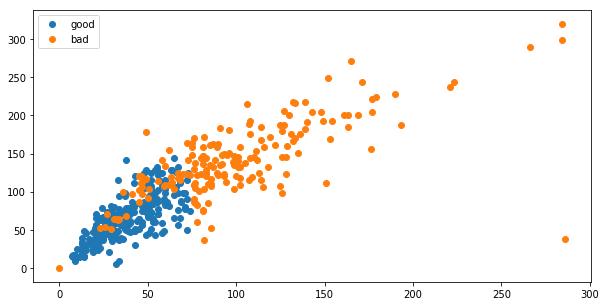

In [6]:
X_good = X_test[y_test==1]
X_bad = X_test[y_test==0]

plt.figure(figsize=(10,5))
plt.scatter(X_good['PM2.5'], X_good['PM10'], label='good')
plt.scatter(X_bad['PM2.5'], X_bad['PM10'], label='bad')
plt.legend()
plt.show()

## 自定义类

In [0]:
class myLogReg():
    def __init__(self, eta=1e-3, thread=1e-8, max_iter=1e5):
        self._X = None
        self._y = None
        self._theta = None
        self._eta = eta
        self._thread = thread
        self._max_iter = max_iter
    
    def _sigmoid(self, t):
        return 1 / (1 + np.exp(-t))
    
    def _entropy(self, h):
        return -self._y*np.log(h) - (1-self._y)*np.log(1-h)
    
    # 目标函数
    def _J(self):
        yhat = self._sigmoid(self._X @ self._theta)
        m = len(self._y)
        try:
            return np.sum(self._entropy(yhat)) / (2*m)
        except:
            return float('inf')
    
    # 梯度
    def _dJ(self):
        yhat = self._sigmoid(self._X @ self._theta)
        m = len(self._y)
        return (self._X.T @ (yhat - self._y)) / m
    
    def fit(self, X_train, y_train):
        self._X = np.c_[np.ones(X_train.shape[0]), X_train]
        self._y = y_train.to_numpy().reshape(-1, 1)
        self._theta = np.zeros(self._X.shape[1]).reshape(-1,1)
        count = 1
        while count < self._max_iter:
            old_J = self._J()
            dJ = self._dJ()
            self._theta -= self._eta * dJ
            new_J = self._J()
            if np.abs(new_J - old_J) < self._thread:
                break
            count +=1
        return self
    
    def predict(self, X_test):
        X_b = np.c_[np.ones(X_test.shape[0]), X_test]
        return np.array(X_b@self._theta>0, dtype=np.int64)
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test).reshape(-1,1)
        y_test = y_test.to_numpy().reshape(-1,1)
        return np.sum(y_pred==y_test) / len(y_test)

In [8]:
my_LogReg = myLogReg()
my_LogReg.fit(X_train, y_train)
my_LogReg.score(X_test, y_test)

0.8942731277533039

## 使用sklearn

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
log_reg.score(X_test, y_test)

0.8964757709251101

**决策边界**

$X\theta=0$

In [0]:
def plot_decision_boundary(model, axis):
    X0, X1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int(axis[1]-axis[0])).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int(axis[3]-axis[2])).reshape(-1, 1),
    )
    X = np.c_[X0.ravel(), X1.ravel()]
    Y = model.predict(X).reshape(X0.shape)
    
    plt.contourf(X0, X1, Y)

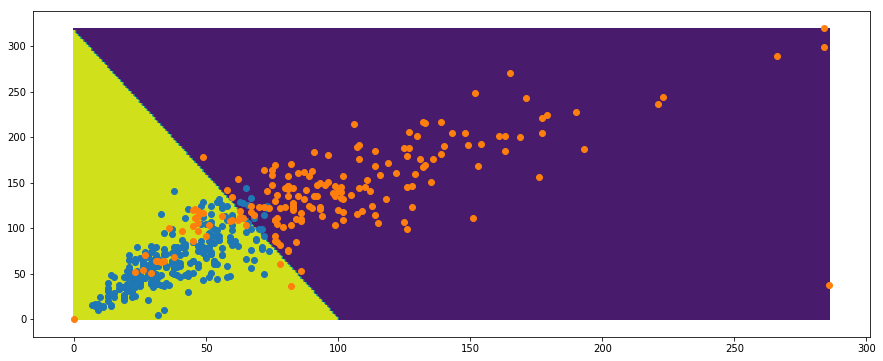

In [12]:
plt.figure(figsize=(15,6))
plot_decision_boundary(log_reg, axis=[np.min(X_test)[0],np.max(X_test)[0], np.min(X_test)[0],np.max(X_test)[1]])
plt.scatter(X_good['PM2.5'], X_good['PM10'])
plt.scatter(X_bad['PM2.5'], X_bad['PM10'])
plt.show()

**加入多项式特征**

In [0]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

def PolynomialLogisticRegression(degree):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('log_reg', LogisticRegression())
    ])

In [14]:
poly_log_reg = PolynomialLogisticRegression(2)
poly_log_reg.fit(X_train, y_train)
poly_log_reg.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9008810572687225

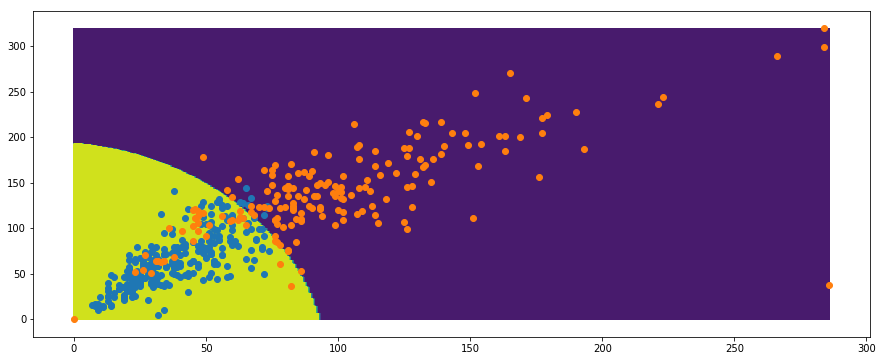

In [15]:
plt.figure(figsize=(15,6))
plot_decision_boundary(poly_log_reg, axis=[np.min(X_test)[0],np.max(X_test)[0], np.min(X_test)[0],np.max(X_test)[1]])
plt.scatter(X_good['PM2.5'], X_good['PM10'])
plt.scatter(X_bad['PM2.5'], X_bad['PM10'])
plt.show()